In [113]:
import json
import numpy as np
from pathlib import Path
from collections import defaultdict


In [114]:
RUNS_DIR = Path("../runs")

# data[study][condition] = list of metric dicts (one per run)
data = defaultdict(lambda: defaultdict(list))

for run_dir in RUNS_DIR.iterdir():
    if not run_dir.is_dir():
        continue

    for study_dir in run_dir.iterdir():
        if not study_dir.is_dir():
            continue

        study_name = study_dir.name

        for condition_dir in study_dir.iterdir():
            metrics_path = condition_dir / "metrics.json"
            if not metrics_path.exists():
                continue

            with open(metrics_path, "r") as f:
                metrics = json.load(f)

            condition_name = condition_dir.name
            data[study_name][condition_name].append(metrics)


In [115]:
def aggregate_metrics(metric_list):
    """
    metric_list: list of dicts with identical keys and k values
    returns: dict with mean (and optionally std) per metric
    """
    agg = {}
    keys = metric_list[0].keys()

    for key in keys:
        values = np.array([m[key] for m in metric_list])

        agg[key] = {
            "mean": values.mean(axis=0),
            "std": values.std(axis=0)
        }

    return agg


In [116]:
aggregated = {}

for study_name, conditions in data.items():
    aggregated[study_name] = {}

    for condition_name, runs in conditions.items():
        aggregated[study_name][condition_name] = aggregate_metrics(runs)


In [117]:
aggregated["alpha_study"]["alpha_0.5"]["mean_overlap"]["mean"]
aggregated["alpha_study"]["alpha_0.5"]["mean_overlap"]["std"]


array([0.00191621, 0.00133226, 0.00114243, 0.00091084, 0.00101374,
       0.00097295, 0.00097976, 0.00094899, 0.00094072, 0.00088042,
       0.0008224 , 0.00083951, 0.00080452, 0.0008361 , 0.00085134,
       0.00088044, 0.00089377, 0.00087519, 0.00082935, 0.00081097,
       0.00077709, 0.00078844, 0.00074437, 0.0007387 , 0.00077917,
       0.0007842 , 0.00078984, 0.00080852, 0.00082212, 0.00087086,
       0.00091036, 0.00092979, 0.00100207, 0.00106082, 0.00106772,
       0.00108901, 0.00109255, 0.00111215, 0.00112306, 0.00111557,
       0.00111459, 0.00110654, 0.00111988, 0.0011248 , 0.00113817,
       0.0011383 , 0.00113725, 0.0011375 , 0.00112142, 0.00111117])

In [118]:
for study in aggregated:
    for cond in aggregated[study]:
        ks = aggregated[study][cond]["k"]["mean"]
        assert np.all(ks == aggregated[study][cond]["k"]["mean"])

In [119]:
for study in data:
    for cond, runs in data[study].items():
        print(study, cond, len(runs))


efSearch_study ef_25 10
efSearch_study ef_100 10
efSearch_study ef_50 10
efSearch_study ef_75 10
efConstruction_study efc_400 10
efConstruction_study efc_300 10
efConstruction_study efc_200 10
efConstruction_study efc_100 10
efConstruction_study efc_50 10
alpha_study alpha_0.25 10
alpha_study alpha_4.0 10
alpha_study alpha_2.0 10
alpha_study alpha_0.5 10
alpha_study alpha_1.0 10


In [120]:
def truncate_at_failure(k, y, k_fail):
    if k_fail is None:
        return k, np.asarray(y)
    mask = k <= k_fail
    return k[mask], np.asarray(y)[mask]


In [121]:
import matplotlib.pyplot as plt

def plot_metric(
    aggregated,
    study_name,
    metric_name,
    title=None,
    ylabel=None,
    legend_title=None
):
    plt.figure(figsize=(7, 5))
    # plt.yscale("log")
    for condition, metrics in aggregated[study_name].items():
        k = metrics["k"]["mean"]
        y = metrics[metric_name]["mean"]
        

        plt.plot(k, y, label=condition)

    plt.xlabel("k")
    plt.ylabel(ylabel if ylabel else metric_name)
    plt.title(title if title else f"{metric_name} ({study_name})")
    plt.legend(title=legend_title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [122]:
def safe(arr):
    arr = np.array(arr, dtype=float)
    arr[~np.isfinite(arr)] = np.nan
    return arr


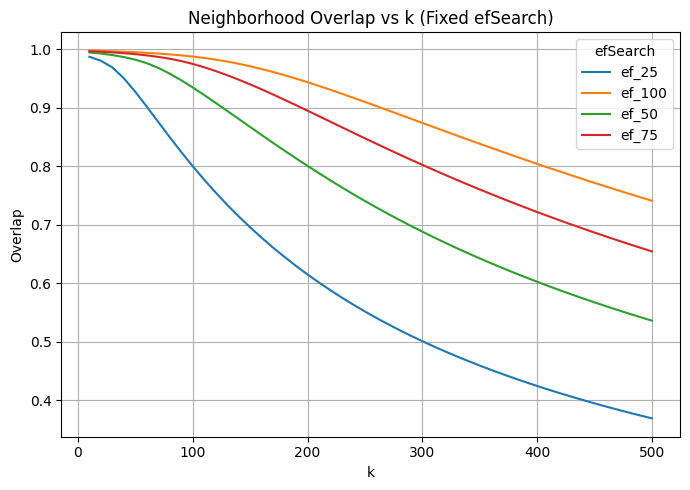

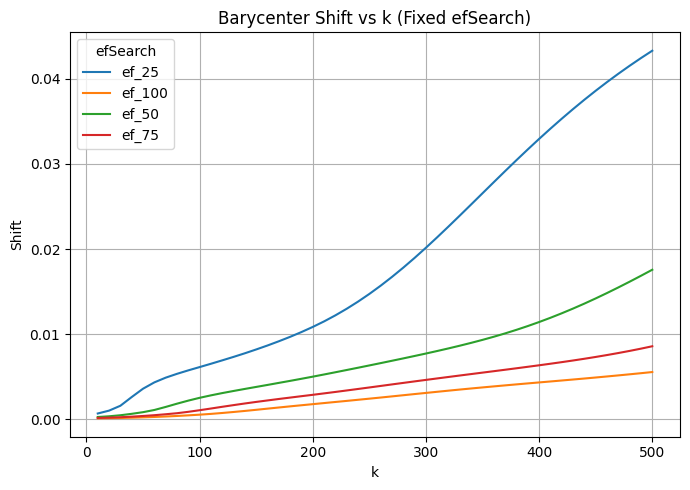

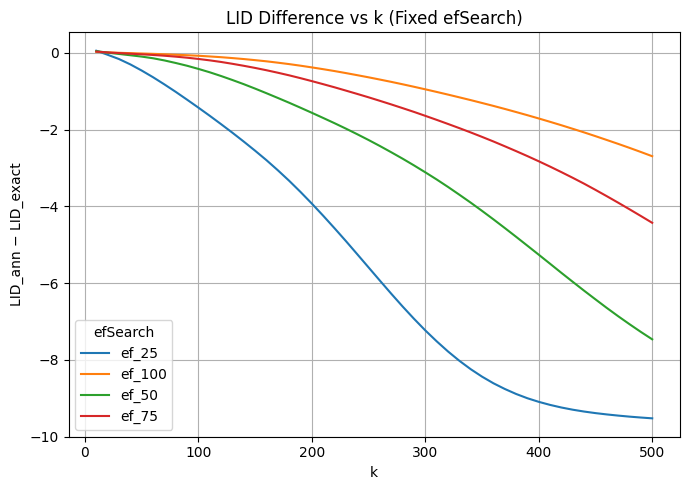

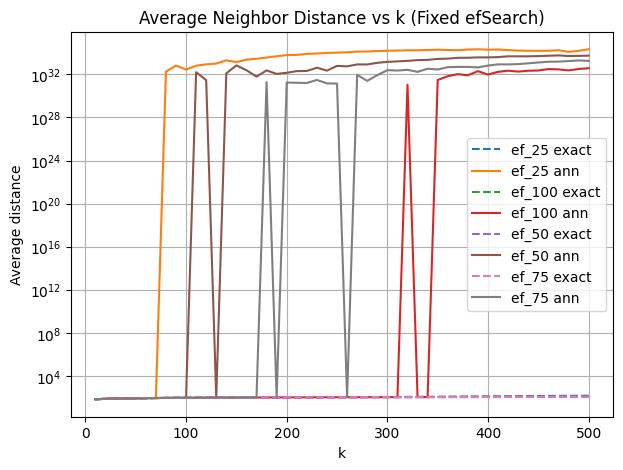

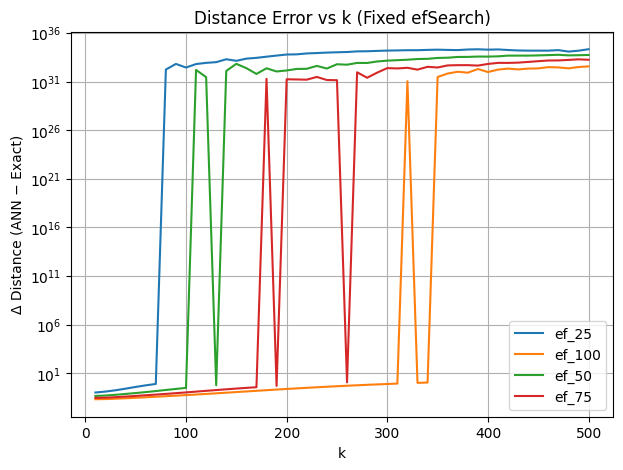

In [123]:
plot_metric(
    aggregated,
    study_name="efSearch_study",
    metric_name="mean_overlap",
    title="Neighborhood Overlap vs k (Fixed efSearch)",
    ylabel="Overlap",
    legend_title="efSearch"
)

plot_metric(
    aggregated,
    "efSearch_study",
    "mean_barycenter_shift",
    title="Barycenter Shift vs k (Fixed efSearch)",
    ylabel="Shift",
    legend_title="efSearch"
)

plot_metric(
    aggregated,
    "efSearch_study",
    "mean_lid_diff",
    title="LID Difference vs k (Fixed efSearch)",
    ylabel="LID_ann − LID_exact",
    legend_title="efSearch"
)

plt.figure(figsize=(7,5))
plt.yscale("log")

for cond, m in aggregated["efSearch_study"].items():
    k = m["k"]["mean"]
    plt.plot(k, safe(m["mean_exact_dist"]["mean"]), "--", label=f"{cond} exact")
    plt.plot(k, safe(m["mean_ann_dist"]["mean"]), "-",  label=f"{cond} ann")

plt.xlabel("k")
plt.ylabel("Average distance")
plt.title("Average Neighbor Distance vs k (Fixed efSearch)")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(7,5))
plt.yscale("log")
for cond, m in aggregated["efSearch_study"].items():
    k = m["k"]["mean"]
    diff = safe(m["mean_ann_dist"]["mean"]) - safe(m["mean_exact_dist"]["mean"])
    plt.plot(k, diff, label=cond)

plt.xlabel("k")
plt.ylabel("Δ Distance (ANN − Exact)")
plt.title("Distance Error vs k (Fixed efSearch)")
plt.legend()
plt.grid(True)
plt.show()


In [124]:
# def rate_of_change(y, k):
#     y = np.asarray(y)
#     k = np.asarray(k)
#     return np.diff(y) / np.diff(k)


In [125]:
# def threshold_crossing(k, y, threshold, direction="below"):
#     for ki, yi in zip(k, y):
#         if direction == "below" and yi < threshold:
#             return ki
#         if direction == "above" and yi > threshold:
#             return ki
#     return None


In [126]:
# def distance_error_breakpoint(k, exact, ann, tol):
#     diff = ann - exact
#     for ki, di in zip(k, diff):
#         if abs(di) > tol:
#             return ki
#     return None


In [127]:
def distance_error_roc_breakpoint(k, exact, ann):
    exact = safe(exact)
    ann = safe(ann)
    diff = ann - exact

    # remove NaNs
    mask = np.isfinite(diff)
    k = np.asarray(k)[mask]
    diff = diff[mask]

    dy = np.diff(diff)
    dk = np.diff(k)
    roc = dy / dk

    idx = np.argmax(roc)
    return k[idx], roc[idx]


In [128]:
def distance_error_threshold(k, exact, ann, tol):
    exact = safe(exact)
    ann = safe(ann)
    diff = ann - exact

    for ki, di in zip(k, diff):
        if np.isfinite(di) and abs(di) > tol:
            return ki
    return None


In [129]:
def hard_failure_k(k, exact_dist, ann_dist, ratio_thresh=10.0):
    exact = np.asarray(exact_dist)
    ann   = np.asarray(ann_dist)

    valid = np.isfinite(ann) & (exact > 0)
    ratio = np.zeros_like(ann)
    ratio[valid] = ann[valid] / exact[valid]

    mask = ratio > ratio_thresh
    if not np.any(mask):
        return None

    return k[np.argmax(mask)]


In [130]:
def roc_breakpoint(k, y, mode="min"):
    """
    k: array of k values
    y: metric values
    mode:
      - "min": most negative slope (overlap, LID diff)
      - "max": most positive slope (barycenter shift)
    """
    k = np.asarray(k)
    y = np.asarray(y)

    dy = np.diff(y)
    dk = np.diff(k)
    roc = dy / dk

    if mode == "min":
        idx = np.argmin(roc)
    elif mode == "max":
        idx = np.argmax(roc)
    else:
        raise ValueError("mode must be 'min' or 'max'")

    return k[idx], roc[idx]


In [131]:
def detect_hard_failure_k(k, exact_dist, ann_dist, ratio_thresh=10.0):
    exact = np.asarray(exact_dist)
    ann   = np.asarray(ann_dist)

    bad = (
        ~np.isfinite(ann) |
        ~np.isfinite(exact) |
        (ann / (exact + 1e-12) > ratio_thresh)
    )

    if not np.any(bad):
        return None

    return k[np.argmax(bad)]


In [132]:
results = []

study = "efSearch_study"

for cond, m in aggregated[study].items():
    ef = int(cond.split("_")[1])

    k = np.asarray(m["k"]["mean"])

    overlap = m["mean_overlap"]["mean"]
    lid_diff = m["mean_lid_diff"]["mean"]
    shift = m["mean_barycenter_shift"]["mean"]

    exact_dist = m["mean_exact_dist"]["mean"]
    ann_dist   = m["mean_ann_dist"]["mean"]

    # existing breakpoints (geometric / structural)
    k_ov, _ = roc_breakpoint(k, overlap, mode="min")
    k_lid, _ = roc_breakpoint(k, lid_diff, mode="min")
    k_shift, _ = roc_breakpoint(k, shift, mode="max")

    # distance: geometric degradation
    k_dist_roc, _ = distance_error_roc_breakpoint(
        k, exact_dist, ann_dist
    )

    k_dist_tol = distance_error_threshold(
        k, exact_dist, ann_dist, tol=2.0
    )

    # distance: HARD algorithmic failure
    k_dist_hard = hard_failure_k(
        k, exact_dist, ann_dist, ratio_thresh=10.0
    )

    results.append({
        "efSearch": ef,

        # structural / geometric
        "overlap_k": k_ov,
        "lid_k": k_lid,
        "shift_k": k_shift,
        "dist_roc_k": k_dist_roc,
        "dist_tol_k": k_dist_tol,

        # HARD failure
        "dist_hard_k": k_dist_hard,

        # normalized ratios
        "overlap_ratio": k_ov / ef,
        "lid_ratio": k_lid / ef,
        "shift_ratio": k_shift / ef,
        "dist_roc_ratio": k_dist_roc / ef if k_dist_roc else None,
        "dist_tol_ratio": k_dist_tol / ef if k_dist_tol else None,
        "dist_hard_ratio": k_dist_hard / ef if k_dist_hard else None,
    })


In [133]:
import pandas as pd

df = pd.DataFrame(results)
df.sort_values("efSearch")


,efSearch,overlap_k,lid_k,shift_k,dist_roc_k,dist_tol_k,dist_hard_k,overlap_ratio,lid_ratio,shift_ratio,dist_roc_ratio,dist_tol_ratio,dist_hard_ratio
0,25,60.0,250.0,340.0,490.0,80.0,80.0,2.4,10.000000,13.600000,19.6,3.2,3.2
2,50,140.0,410.0,490.0,410.0,110.0,110.0,2.8,8.200000,9.800000,8.2,2.2,2.2
3,75,210.0,490.0,490.0,480.0,180.0,180.0,2.8,6.533333,6.533333,6.4,2.4,2.4
1,100,280.0,490.0,150.0,380.0,320.0,320.0,2.8,4.900000,1.500000,3.8,3.2,3.2


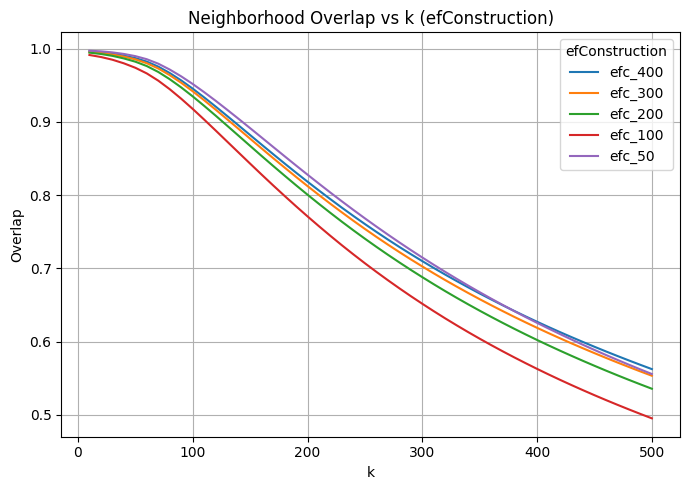

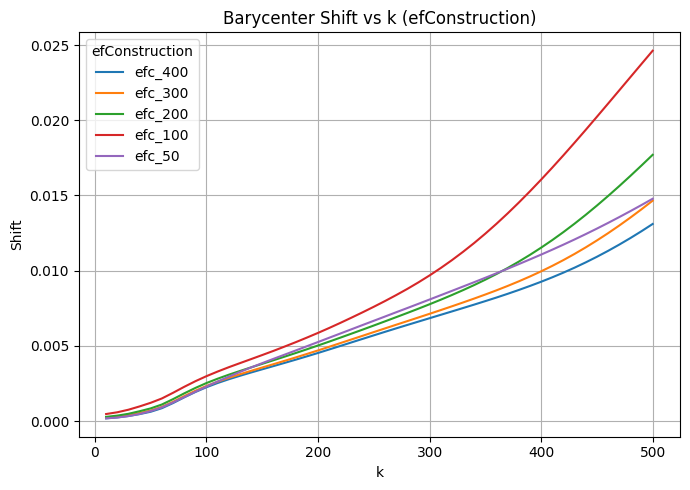

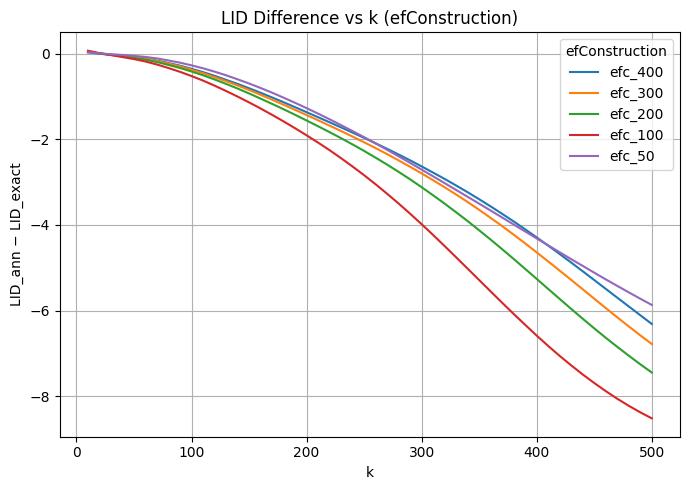

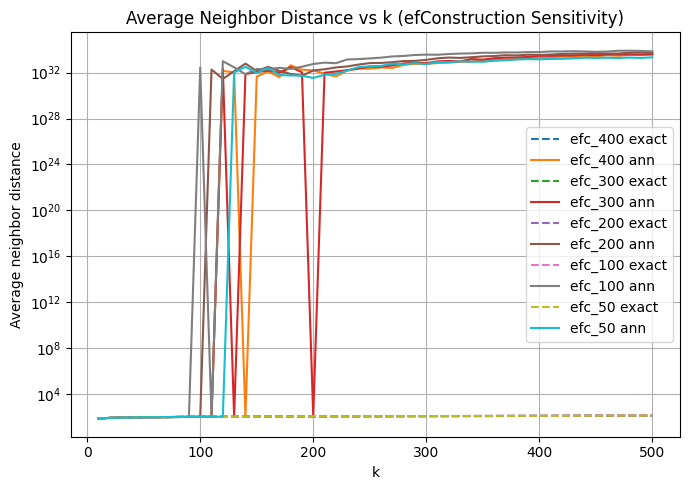

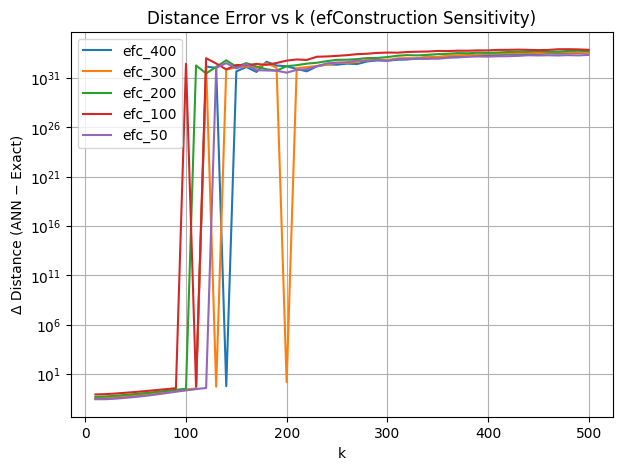

In [134]:

plot_metric(
    aggregated,
    "efConstruction_study",
    "mean_overlap",
    title="Neighborhood Overlap vs k (efConstruction)",
    ylabel="Overlap",
    legend_title="efConstruction"
)

plot_metric(
    aggregated,
    "efConstruction_study",
    "mean_barycenter_shift",
    title="Barycenter Shift vs k (efConstruction)",
    ylabel="Shift",
    legend_title="efConstruction"
)

plot_metric(
    aggregated,
    "efConstruction_study",
    "mean_lid_diff",
    title="LID Difference vs k (efConstruction)",
    ylabel="LID_ann − LID_exact",
    legend_title="efConstruction"
)

plt.figure(figsize=(7, 5))
plt.yscale("log")

for cond, m in aggregated["efConstruction_study"].items():
    k = m["k"]["mean"]

    exact = safe(m["mean_exact_dist"]["mean"])
    ann   = safe(m["mean_ann_dist"]["mean"])

    plt.plot(k, exact, "--", label=f"{cond} exact")
    plt.plot(k, ann,   "-",  label=f"{cond} ann")

plt.xlabel("k")
plt.ylabel("Average neighbor distance")
plt.title("Average Neighbor Distance vs k (efConstruction Sensitivity)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(7,5))
plt.yscale("log")
for cond, m in aggregated["efConstruction_study"].items():
    k = m["k"]["mean"]
    diff = safe(m["mean_ann_dist"]["mean"]) - safe(m["mean_exact_dist"]["mean"])
    plt.plot(k, diff, label=cond)

plt.xlabel("k")
plt.ylabel("Δ Distance (ANN − Exact)")
plt.title("Distance Error vs k (efConstruction Sensitivity)")
plt.legend()
plt.grid(True)
plt.show()



In [135]:
results_ec = []

study = "efConstruction_study"

for cond, m in aggregated[study].items():
    efc = int(cond.split("_")[1])  # efConstruction

    k = np.asarray(m["k"]["mean"])

    overlap = m["mean_overlap"]["mean"]
    lid_diff = m["mean_lid_diff"]["mean"]
    shift = m["mean_barycenter_shift"]["mean"]

    exact_dist = m["mean_exact_dist"]["mean"]
    ann_dist   = m["mean_ann_dist"]["mean"]

    # structural breakpoints
    k_ov, _    = roc_breakpoint(k, overlap, mode="min")
    k_lid, _   = roc_breakpoint(k, lid_diff, mode="min")
    k_shift, _ = roc_breakpoint(k, shift, mode="max")

    # distance breakpoints
    k_dist_roc, _ = distance_error_roc_breakpoint(k, exact_dist, ann_dist)
    k_dist_tol = distance_error_threshold(
        k, exact_dist, ann_dist, tol=2.0
    )

    # hard / capacity failure (distance explosion)
    k_dist_hard = hard_failure_k(
        k, exact_dist, ann_dist, ratio_thresh=10.0
    )

    results_ec.append({
        "efConstruction": efc,

        # absolute k breakpoints
        "overlap_k": k_ov,
        "lid_k": k_lid,
        "shift_k": k_shift,
        "dist_roc_k": k_dist_roc,
        "dist_tol_k": k_dist_tol,
        "dist_hard_k": k_dist_hard,

        # normalized ratios (diagnostic)
        "overlap_ratio": k_ov / efc if k_ov else None,
        "lid_ratio": k_lid / efc if k_lid else None,
        "shift_ratio": k_shift / efc if k_shift else None,
        "dist_roc_ratio": k_dist_roc / efc if k_dist_roc else None,
        "dist_tol_ratio": k_dist_tol / efc if k_dist_tol else None,
        "dist_hard_ratio": k_dist_hard / efc if k_dist_hard else None,
    })


In [136]:
df_ec = pd.DataFrame(results_ec).sort_values("efConstruction")
df_ec


,efConstruction,overlap_k,lid_k,shift_k,dist_roc_k,dist_tol_k,dist_hard_k,overlap_ratio,lid_ratio,shift_ratio,dist_roc_ratio,dist_tol_ratio,dist_hard_ratio
4,50,160.0,370.0,490.0,300.0,130.0,130.0,3.200000,7.400000,9.800000,6.000,2.60,2.60
3,100,120.0,340.0,470.0,460.0,100.0,100.0,1.200000,3.400000,4.700000,4.600,1.00,1.00
2,200,140.0,400.0,490.0,470.0,110.0,110.0,0.700000,2.000000,2.450000,2.350,0.55,0.55
1,300,140.0,440.0,490.0,390.0,120.0,120.0,0.466667,1.466667,1.633333,1.300,0.40,0.40
0,400,140.0,450.0,490.0,450.0,120.0,120.0,0.350000,1.125000,1.225000,1.125,0.30,0.30


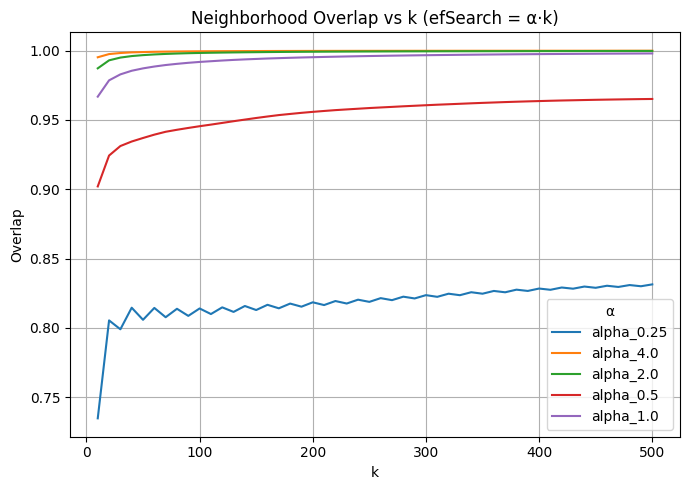

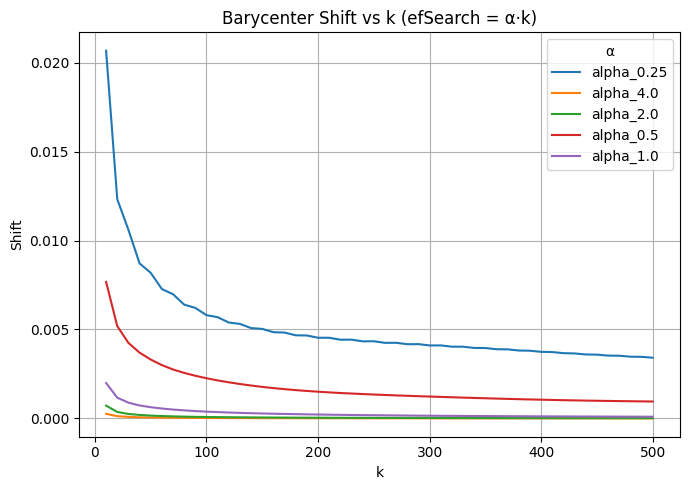

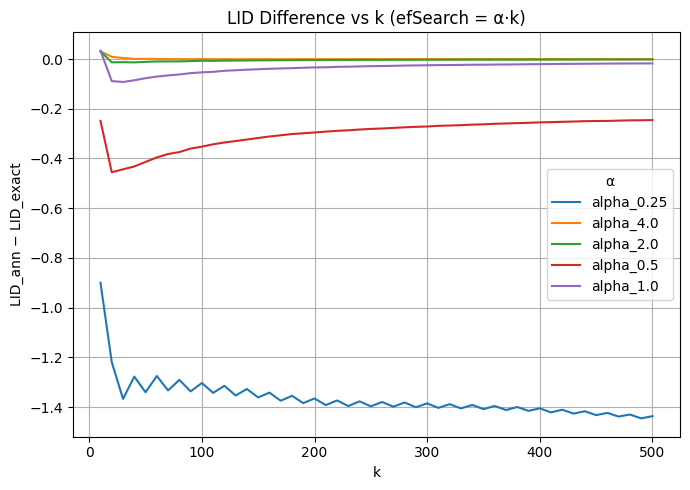

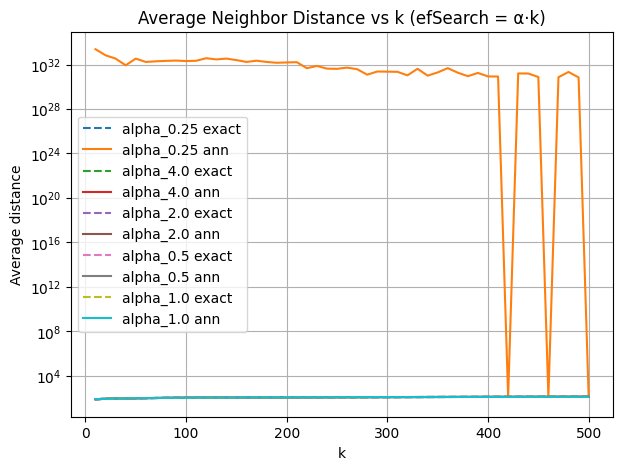

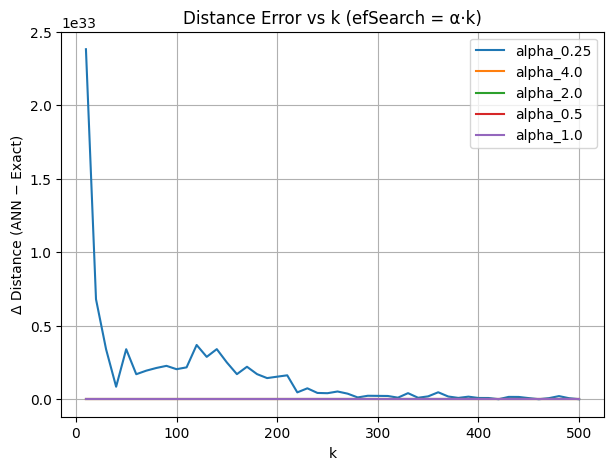

In [137]:
plot_metric(
    aggregated,
    "alpha_study",
    "mean_overlap",
    title="Neighborhood Overlap vs k (efSearch = α·k)",
    ylabel="Overlap",
    legend_title="α"
)

plot_metric(
    aggregated,
    "alpha_study",
    "mean_barycenter_shift",
    title="Barycenter Shift vs k (efSearch = α·k)",
    ylabel="Shift",
    legend_title="α"
)

plot_metric(
    aggregated,
    "alpha_study",
    "mean_lid_diff",
    title="LID Difference vs k (efSearch = α·k)",
    ylabel="LID_ann − LID_exact",
    legend_title="α"
)

plt.figure(figsize=(7,5))
plt.yscale("log")
for cond, m in aggregated["alpha_study"].items():
    k = m["k"]["mean"]
    plt.plot(k, safe(m["mean_exact_dist"]["mean"]), "--", label=f"{cond} exact")
    plt.plot(k, safe(m["mean_ann_dist"]["mean"]), "-",  label=f"{cond} ann")

plt.xlabel("k")
plt.ylabel("Average distance")
plt.title("Average Neighbor Distance vs k (efSearch = α·k)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,5))
for cond, m in aggregated["alpha_study"].items():
    k = m["k"]["mean"]
    diff = safe(m["mean_ann_dist"]["mean"]) - safe(m["mean_exact_dist"]["mean"])
    plt.plot(k, diff, label=cond)

plt.xlabel("k")
plt.ylabel("Δ Distance (ANN − Exact)")
plt.title("Distance Error vs k (efSearch = α·k)")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
results_alpha = []
study = "alpha_study"

def eff_at_k(alpha, k, ef_min=2):
    return max(ef_min, int(alpha * k))

for cond, m in aggregated[study].items():
    alpha = float(cond.split("_")[1]) 

    k = np.asarray(m["k"]["mean"])

    overlap  = m["mean_overlap"]["mean"]
    lid_diff = m["mean_lid_diff"]["mean"]
    shift    = m["mean_barycenter_shift"]["mean"]

    exact_dist = m["mean_exact_dist"]["mean"]
    ann_dist   = m["mean_ann_dist"]["mean"]

    # --- breakpoints like before ---
    k_ov, _    = roc_breakpoint(k, overlap,  mode="min")
    k_lid, _   = roc_breakpoint(k, lid_diff, mode="min")
    k_shift, _ = roc_breakpoint(k, shift,    mode="max")

    k_dist_roc, _ = distance_error_roc_breakpoint(k, exact_dist, ann_dist)
    k_dist_tol = distance_error_threshold(k, exact_dist, ann_dist, tol=2.0)
    k_dist_hard = hard_failure_k(k, exact_dist, ann_dist, ratio_thresh=10.0)

    # --- effective ef at those breakpoints (IMPORTANT for alpha study) ---
    eff_ov   = eff_at_k(alpha, k_ov)        if k_ov   else None
    eff_lid  = eff_at_k(alpha, k_lid)       if k_lid  else None
    eff_shift= eff_at_k(alpha, k_shift)     if k_shift else None
    eff_roc  = eff_at_k(alpha, k_dist_roc)  if k_dist_roc else None
    eff_tol  = eff_at_k(alpha, k_dist_tol)  if k_dist_tol else None
    eff_hard = eff_at_k(alpha, k_dist_hard) if k_dist_hard else None

    results_alpha.append({
        "alpha": alpha,

        "overlap_k": k_ov,
        "lid_k": k_lid,
        "shift_k": k_shift,
        "dist_roc_k": k_dist_roc,
        "dist_tol_k": k_dist_tol,
        "dist_hard_k": k_dist_hard,

        # ratios vs alpha (rough, but intuitive)
        "overlap_ratio_k_over_alpha": (k_ov / alpha) if (k_ov and alpha > 0) else None,
        "lid_ratio_k_over_alpha":     (k_lid / alpha) if (k_lid and alpha > 0) else None,
        "shift_ratio_k_over_alpha":   (k_shift / alpha) if (k_shift and alpha > 0) else None,

        # ratios vs effective ef at that breakpoint (better)
        "overlap_ratio_k_over_eff": (k_ov / eff_ov) if (k_ov and eff_ov) else None,
        "lid_ratio_k_over_eff":     (k_lid / eff_lid) if (k_lid and eff_lid) else None,
        "shift_ratio_k_over_eff":   (k_shift / eff_shift) if (k_shift and eff_shift) else None,
        "dist_hard_ratio_k_over_eff": (k_dist_hard / eff_hard) if (k_dist_hard and eff_hard) else None,

        # also useful to *report directly*:
        "eff_at_overlap_k": eff_ov,
        "eff_at_dist_hard_k": eff_hard,
    })

df_alpha = pd.DataFrame(results_alpha).sort_values("alpha", ascending=True)
df_alpha


,alpha,overlap_k,lid_k,shift_k,dist_roc_k,dist_tol_k,dist_hard_k,overlap_ratio_k_over_alpha,lid_ratio_k_over_alpha,shift_ratio_k_over_alpha,overlap_ratio_k_over_eff,lid_ratio_k_over_eff,shift_ratio_k_over_eff,dist_hard_ratio_k_over_eff,eff_at_overlap_k,eff_at_dist_hard_k
0,0.25,40.0,10.0,280.0,40.0,10.0,10.0,160.0,40.0,1120.0,4.00,5.00,4.00,5.0,10,2.0
3,0.50,490.0,10.0,490.0,490.0,NaN,NaN,980.0,20.0,980.0,2.00,2.00,2.00,NaN,245,NaN
4,1.00,480.0,10.0,490.0,490.0,NaN,NaN,480.0,10.0,490.0,1.00,1.00,1.00,NaN,480,NaN
2,2.00,480.0,10.0,480.0,490.0,NaN,NaN,240.0,5.0,240.0,0.50,0.50,0.50,NaN,960,NaN
1,4.00,480.0,10.0,480.0,490.0,NaN,NaN,120.0,2.5,120.0,0.25,0.25,0.25,NaN,1920,NaN


In [139]:
def max_safe_k(k, overlap, lid_diff, exact_dist, ann_dist,
               overlap_min=0.99, lid_abs_max=0.05, hard_ratio=10.0):
    k = np.asarray(k)
    hard = np.array([ (ad / ed) > hard_ratio if (ed > 0) else True
                      for ed, ad in zip(exact_dist, ann_dist) ])

    ok = (np.asarray(overlap) >= overlap_min) & (np.abs(np.asarray(lid_diff)) <= lid_abs_max) & (~hard)
    return k[ok].max() if ok.any() else None

rows = []
for cond, m in aggregated["alpha_study"].items():
    alpha = float(cond.split("_")[1])
    k = np.asarray(m["k"]["mean"])

    rows.append({
        "alpha": alpha,
        "max_safe_k": max_safe_k(
            k,
            m["mean_overlap"]["mean"],
            m["mean_lid_diff"]["mean"],
            m["mean_exact_dist"]["mean"],
            m["mean_ann_dist"]["mean"],
        )
    })

pd.DataFrame(rows).sort_values("alpha")


,alpha,max_safe_k
0,0.25,NaN
3,0.50,NaN
4,1.00,500.0
2,2.00,500.0
1,4.00,500.0


In [140]:
import matplotlib.pyplot as plt

def plot_alpha_metric_ge1(
    aggregated,
    metric_name,
    title=None,
    ylabel=None,
    legend_title=r"$\alpha$"
):
    plt.figure(figsize=(7, 5))

    for condition, metrics in aggregated["alpha_study"].items():
        alpha = float(condition.split("_")[1])
        if alpha < 1.0:
            continue  # 🔑 only valid regime

        k = metrics["k"]["mean"]
        y = metrics[metric_name]["mean"]
        plt.plot(k, y, label=f"$\\alpha={alpha}$")

    plt.xlabel("k")
    plt.ylabel(ylabel if ylabel else metric_name)
    plt.title(title if title else metric_name)
    plt.legend(title=legend_title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [141]:
import matplotlib.pyplot as plt

def plot_alpha_distance_diff_ge1(
    aggregated,
    title=r"Distance Error vs $k$ ($\alpha \geq 1$)",
    ylabel=r"$\Delta d = d_{\mathrm{ANN}} - d_{\mathrm{exact}}$",
    legend_title=r"$\alpha$",
    logy=True
):
    plt.figure(figsize=(7, 5))

    if logy:
        plt.yscale("log")

    for condition, metrics in aggregated["alpha_study"].items():
        alpha = float(condition.split("_")[1])
        if alpha < 1.0:
            continue  # 🔑 valid regime only

        k = metrics["k"]["mean"]
        diff = (
            safe(metrics["mean_ann_dist"]["mean"])
            - safe(metrics["mean_exact_dist"]["mean"])
        )

        plt.plot(k, diff, label=f"$\\alpha={alpha}$")

    plt.xlabel("k")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(title=legend_title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


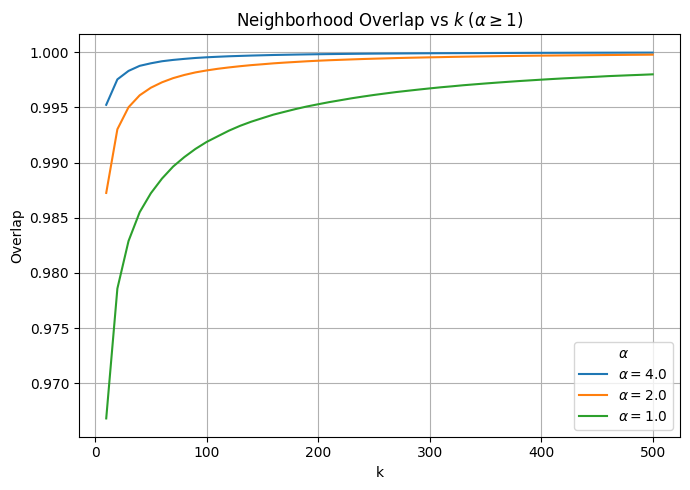

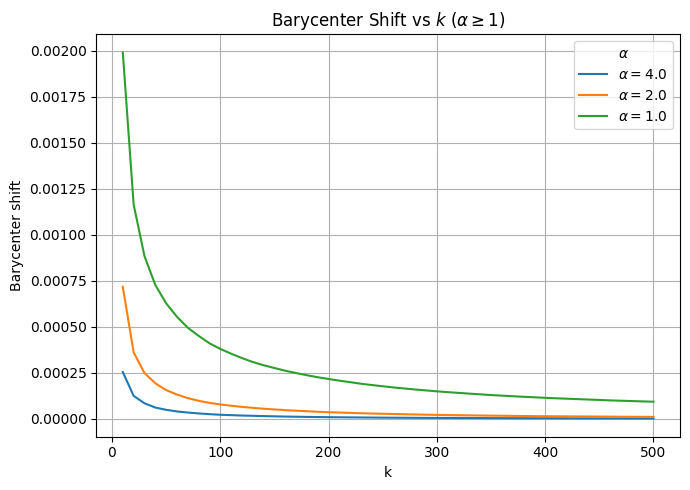

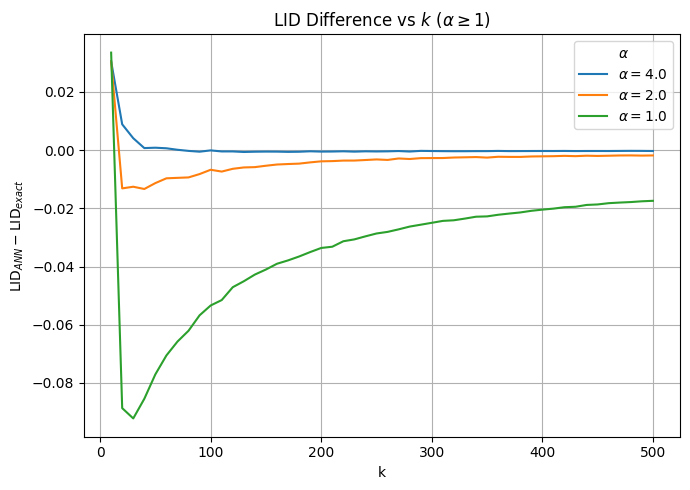

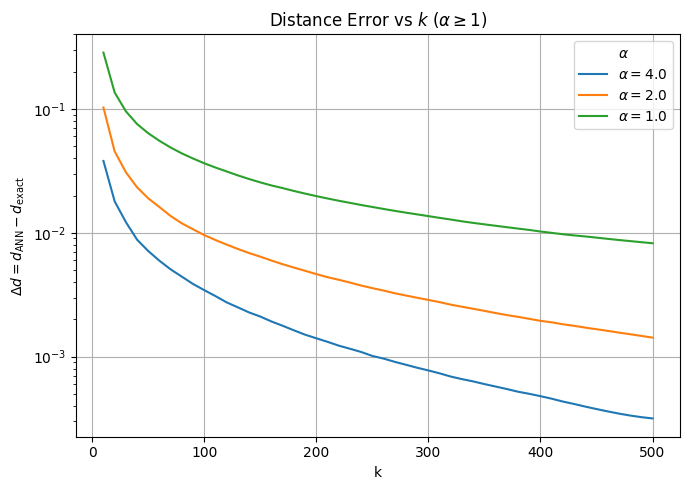

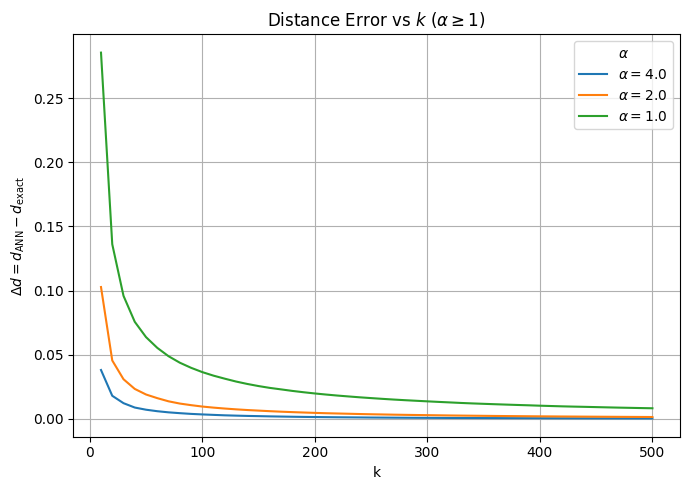

In [142]:
plot_alpha_metric_ge1(
    aggregated,
    metric_name="mean_overlap",
    title=r"Neighborhood Overlap vs $k$ ($\alpha \geq 1$)",
    ylabel="Overlap"
)

plot_alpha_metric_ge1(
    aggregated,
    metric_name="mean_barycenter_shift",
    title=r"Barycenter Shift vs $k$ ($\alpha \geq 1$)",
    ylabel="Barycenter shift"
)

plot_alpha_metric_ge1(
    aggregated,
    metric_name="mean_lid_diff",
    title=r"LID Difference vs $k$ ($\alpha \geq 1$)",
    ylabel=r"$\mathrm{LID}_{ANN} - \mathrm{LID}_{exact}$"
)

plot_alpha_distance_diff_ge1(aggregated)

plot_alpha_distance_diff_ge1(aggregated, logy=False)



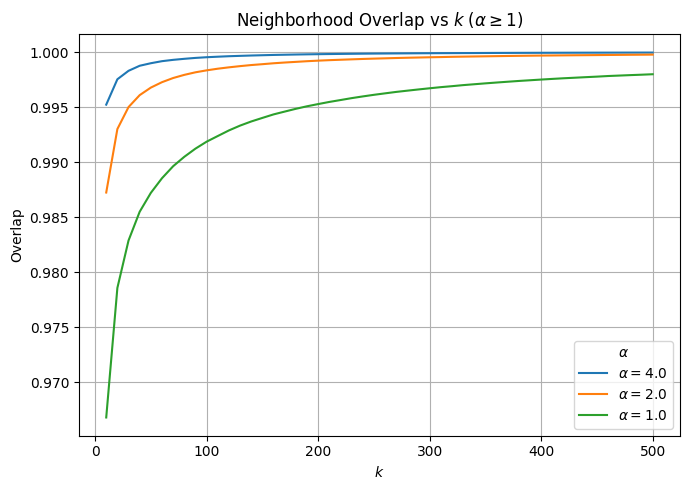

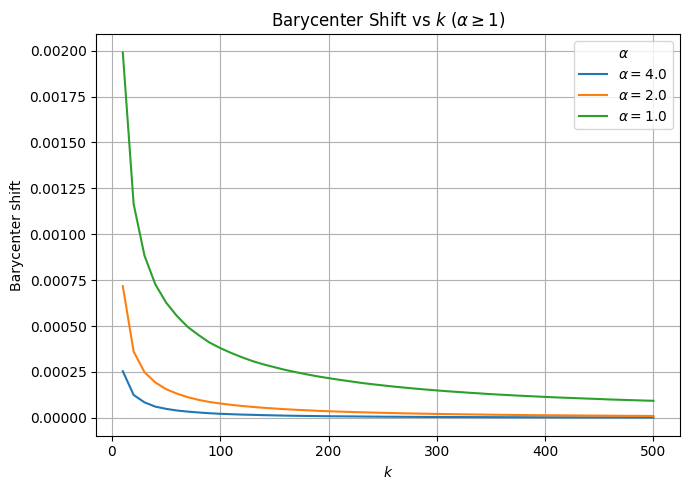

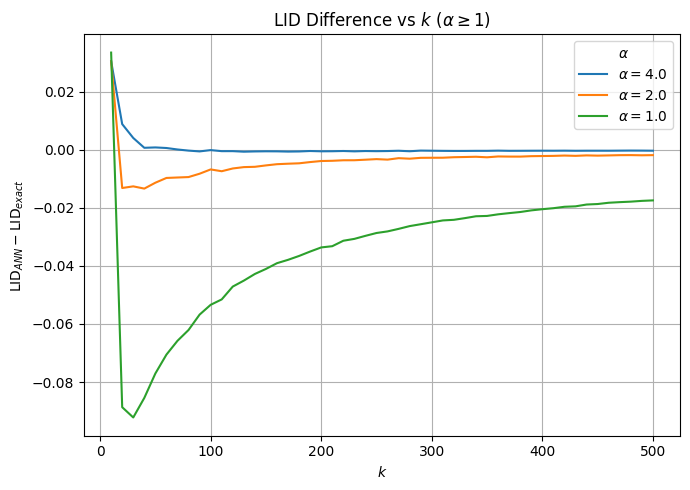

In [143]:
import matplotlib.pyplot as plt
import numpy as np

def plot_alpha_metric_ge1(
    aggregated,
    metric_name,
    title=None,
    ylabel=None,
    legend_title=r"$\alpha$"
):
    plt.figure(figsize=(7, 5))

    for condition, metrics in aggregated["alpha_study"].items():
        alpha = float(condition.split("_")[1])
        if alpha < 1.0:
            continue

        k = np.asarray(metrics["k"]["mean"])
        y = np.asarray(metrics[metric_name]["mean"])

        # ---- CUT OFF k < 10 ----
        mask = k >= 10
        k = k[mask]
        y = y[mask]

        plt.plot(k, y, label=rf"$\alpha={alpha}$")

    plt.xlabel(r"$k$")
    plt.ylabel(ylabel if ylabel else metric_name)
    plt.title(title)
    plt.legend(title=legend_title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_alpha_metric_ge1(
    aggregated,
    metric_name="mean_overlap",
    title=r"Neighborhood Overlap vs $k$ ($\alpha \geq 1$)",
    ylabel="Overlap"
)

plot_alpha_metric_ge1(
    aggregated,
    metric_name="mean_barycenter_shift",
    title=r"Barycenter Shift vs $k$ ($\alpha \geq 1$)",
    ylabel="Barycenter shift"
)

plot_alpha_metric_ge1(
    aggregated,
    metric_name="mean_lid_diff",
    title=r"LID Difference vs $k$ ($\alpha \geq 1$)",
    ylabel=r"$\mathrm{LID}_{ANN} - \mathrm{LID}_{exact}$"
)
